# Libraries

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import seaborn as sns ; sns.set()

k:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data

In [2]:
dataframe = pd.read_csv(r'K:\Projects\misc\data\heart.csv')

In [3]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null object
target      303 non-null int64
dtypes: float64(1), int64(12), object(1)
memory usage: 33.2+ KB


In [5]:
dataframe.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.594059,0.676568,3.108911,131.785479,246.547855,0.148515,0.990099,149.194719,0.326733,1.057756,1.590759,0.683168,0.273927
std,9.016370,0.468560,1.028414,17.748338,52.175933,0.356198,0.988293,23.173368,0.469794,1.165025,0.617767,0.937773,0.446710
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,152.000000,0.000000,0.800000,2.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,165.500000,1.000000,1.600000,2.000000,1.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


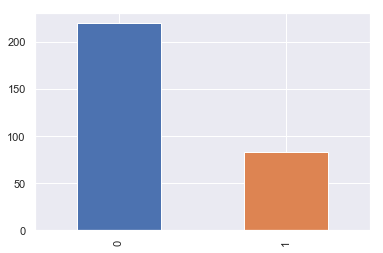

In [6]:
dataframe['target'].value_counts().plot(kind='bar')

In [7]:
dataframe['target'].value_counts() / dataframe.shape[0] * 100

0    72.607261
1    27.392739
Name: target, dtype: float64

## Split data into train, val, test

In [8]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

193 train examples
49 validation examples
61 test examples


## Input Pipeline

In [9]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
    return ds

In [10]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

### Understanding input pipeline

In [11]:
# each tensor has 5 items from batch size = 5
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['age'])
    print('A batch of targets:', label_batch )

Every feature: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
A batch of ages: tf.Tensor([54 62 59 49 68], shape=(5,), dtype=int32)
A batch of targets: tf.Tensor([0 1 0 0 0], shape=(5,), dtype=int32)


In [12]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0] ; example_batch

{'age': <tf.Tensor: id=81, shape=(5,), dtype=int32, numpy=array([53, 58, 58, 46, 66])>,
 'sex': <tf.Tensor: id=89, shape=(5,), dtype=int32, numpy=array([1, 0, 0, 1, 1])>,
 'cp': <tf.Tensor: id=84, shape=(5,), dtype=int32, numpy=array([4, 4, 4, 2, 4])>,
 'trestbps': <tf.Tensor: id=93, shape=(5,), dtype=int32, numpy=array([142, 170, 130, 101, 112])>,
 'chol': <tf.Tensor: id=83, shape=(5,), dtype=int32, numpy=array([226, 225, 197, 197, 212])>,
 'fbs': <tf.Tensor: id=86, shape=(5,), dtype=int32, numpy=array([0, 1, 0, 1, 0])>,
 'restecg': <tf.Tensor: id=88, shape=(5,), dtype=int32, numpy=array([2, 2, 0, 0, 2])>,
 'thalach': <tf.Tensor: id=92, shape=(5,), dtype=int32, numpy=array([111, 146, 131, 156, 132])>,
 'exang': <tf.Tensor: id=85, shape=(5,), dtype=int32, numpy=array([1, 1, 0, 0, 1])>,
 'oldpeak': <tf.Tensor: id=87, shape=(5,), dtype=float64, numpy=array([0. , 2.8, 0.6, 0. , 0.1])>,
 'slope': <tf.Tensor: id=90, shape=(5,), dtype=int32, numpy=array([1, 2, 2, 1, 1])>,
 'ca': <tf.Tensor: 

# Creating feature columns

* To set column type (numeric column)
* Binning (bucketized column)
* One hot encoding (indicator column)

## Numeric columns

In [13]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    #print(feature_layer(example_batch).numpy())
    return feature_layer(example_batch).numpy()

In [14]:
age = feature_column.numeric_column("age")
demo(age)

W1230 16:40:16.951792 30744 base_layer.py:1814] Layer dense_features is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[53.],
       [58.],
       [58.],
       [46.],
       [66.]], dtype=float32)

## Bucketized column (Binning)

In [15]:
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
demo(age_buckets)

W1230 16:40:16.990796 30744 base_layer.py:1814] Layer dense_features_1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## One hot encode 

In [16]:
thal = feature_column.categorical_column_with_vocabulary_list(
      'thal', ['fixed', 'normal', 'reversible'])

thal_one_hot = feature_column.indicator_column(thal)
demo(thal_one_hot)

W1230 16:40:17.036792 30744 base_layer.py:1814] Layer dense_features_2 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W1230 16:40:17.042790 30744 deprecation.py:323] From K:\anaconda3\envs\tf2_k\lib\site-packages\tensorflow_core\python\feature_column\feature_column_v2.py:4276: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) i

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

**Feature columns are most valuable when working with categorical data. **

## Embedding columns

**Very useful for categorical variables with high cardinality (many distinct values)**

Suppose instead of having just a few possible strings, we have thousands (or more) values per category. For a number of reasons, as the number of categories grow large, it becomes infeasible to train a neural network using one-hot encodings. We can use an embedding column to overcome this limitation. Instead of representing the data as a one-hot vector of many dimensions, an embedding column represents that data as a lower-dimensional, dense vector in which each cell can contain any number, not just 0 or 1. The size of the embedding (8, in the example below) is a parameter that must be tuned.

Key point: using an embedding column is best when a categorical column has many possible values. We are using one here for demonstration purposes, so you have a complete example you can modify for a different dataset in the future.

In [17]:
# Notice the input to the embedding column is the categorical column
# we previously created
thal_embedding = feature_column.embedding_column(thal, dimension=8)
demo(thal_embedding)

W1230 16:40:17.083788 30744 base_layer.py:1814] Layer dense_features_3 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[ 0.20418523, -0.5647383 , -0.38869104, -0.21340516,  0.04121806,
         0.09303422, -0.33733475, -0.12402525],
       [ 0.54466605,  0.07586756, -0.02149458,  0.1169752 , -0.22371726,
        -0.0999952 ,  0.23986796, -0.20381168],
       [ 0.21646553,  0.23373596,  0.17646052, -0.1467298 ,  0.5321569 ,
        -0.16558875,  0.01623316,  0.3240398 ],
       [ 0.20418523, -0.5647383 , -0.38869104, -0.21340516,  0.04121806,
         0.09303422, -0.33733475, -0.12402525],
       [ 0.21646553,  0.23373596,  0.17646052, -0.1467298 ,  0.5321569 ,
        -0.16558875,  0.01623316,  0.3240398 ]], dtype=float32)

## Hashed feature columns
Another way to represent a categorical column with a large number of values is to use a categorical_column_with_hash_bucket. This feature column calculates a hash value of the input, then selects one of the hash_bucket_size buckets to encode a string. When using this column, you do not need to provide the vocabulary, and you can choose to make the number of hash_buckets significantly smaller than the number of actual categories to save space.

Key point: An important downside of this technique is that there may be **collisions in which different strings are mapped to the same bucket.** In practice, this can work well for some datasets regardless.

In [18]:
thal_hashed = feature_column.categorical_column_with_hash_bucket(
      'thal', hash_bucket_size=1000)
demo(feature_column.indicator_column(thal_hashed))

W1230 16:40:17.120785 30744 base_layer.py:1814] Layer dense_features_4 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W1230 16:40:17.125788 30744 deprecation.py:323] From K:\anaconda3\envs\tf2_k\lib\site-packages\tensorflow_core\python\feature_column\feature_column_v2.py:4331: HashedCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
t = demo(feature_column.indicator_column(thal_hashed))

W1230 16:40:17.159787 30744 base_layer.py:1814] Layer dense_features_5 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [20]:
t.shape

(5, 1000)

## Cross feature columns

Combining features into a single feature, better known as feature crosses, enables a model to learn separate weights for each combination of features. Here, we will create a new feature that is the cross of age and thal. Note that crossed_column does not build the full table of all possible combinations (which could be very large). Instead, it is backed by a hashed_column, so you can choose how large the table is.

**Currently Bugged**
https://github.com/tensorflow/tensorflow/issues/28846

In [21]:
# crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
# demo(feature_column.indicator_column(crossed_feature))

# Feature columns to train model

In [22]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


## Assigning feature columns

In [23]:
# assigning columns their respective feature columns

feature_columns = []

# numeric cols
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']:
    feature_columns.append(feature_column.numeric_column(header))

# bucketized cols
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# indicator cols
thal = feature_column.categorical_column_with_vocabulary_list(
      'thal', ['fixed', 'normal', 'reversible'])
thal_one_hot = feature_column.indicator_column(thal)
feature_columns.append(thal_one_hot)

# embedding cols
thal_embedding = feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

In [24]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='trestbps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='chol', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='thalach', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='oldpeak', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='slope', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='ca', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 25, 30, 35, 40, 45, 50, 55, 60, 65)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='thal', vocabulary_list=('fixed', 'normal', 'reversi

## Create feature layer

Now that we have defined our feature columns, we will use a DenseFeatures layer to input them to our Keras model.

In [25]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [32]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=True, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=True, batch_size=batch_size)

In [33]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

W1230 16:43:43.162698 30744 base_layer.py:1814] Layer sequential_3 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Epoch 1/5
7/7 [==============================] - 2s 263ms/step - loss: 3.1143 - accuracy: 0.5544 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
7/7 [==============================] - 0s 13ms/step - loss: 3.8165 - accuracy: 0.7306 - val_loss: 0.4148 - val_accuracy: 0.8367
Epoch 3/5
7/7 [==============================] - 0s 13ms/step - loss: 0.7792 - accuracy: 0.6943 - val_loss: 0.8607 - val_accuracy: 0.7347
Epoch 4/5
7/7 [==============================] - 0s 13ms/step - loss: 0.8146 - accuracy: 0.6425 - val_loss: 1.6880 - val_accuracy: 0.6939
Epoch 5/5
7/7 [==============================] - 0s 13ms/step - loss: 1.2213 - accuracy: 0.6373 - val_loss: 1.1289 - val_accuracy: 0.6939


In [34]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

2/2 [==============================] - 0s 5ms/step - loss: 1.1188 - accuracy: 0.7213
Accuracy 0.72131145
